In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from ucimlrepo import fetch_ucirepo

# Set the style for seaborn
sns.set(style="whitegrid", palette="muted")

In [2]:
# Fetch dataset
diabetic_retinopathy_debrecen = fetch_ucirepo(id=329)

# Data (as pandas dataframes)
X = diabetic_retinopathy_debrecen.data.features
y = diabetic_retinopathy_debrecen.data.targets

# Drop duplicate columns
X = X.loc[:, ~X.columns.duplicated()]

# Display first few columns of the features
print(X.head())

# Display info about the dataset
print(X.info())
print(y.info())

# Standardize features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_standardized, y)

   quality  pre_screening  ma1  ma2  ma3  ma4  ma5  ma6   exudate1   exudate2  \
0        1              1   22   22   22   19   18   14  49.895756  17.775994   
1        1              1   24   24   22   18   16   13  57.709936  23.799994   
2        1              1   62   60   59   54   47   33  55.831441  27.993933   
3        1              1   55   53   53   50   43   31  40.467228  18.445954   
4        1              1   44   44   44   41   39   27  18.026254   8.570709   

    exudate3  exudate5  exudate6  exudate7  exudate8  \
0   5.270920  0.018632  0.006864  0.003923  0.003923   
1   3.325423  0.003903  0.003903  0.003903  0.003903   
2  12.687485  1.393889  0.373252  0.041817  0.007744   
3   9.118901  0.840261  0.272434  0.007653  0.001531   
4   0.410381  0.000000  0.000000  0.000000  0.000000   

   macula_opticdisc_distance  opticdisc_diameter  am_fm_classification  
0                   0.486903            0.100025                     1  
1                   0.520908  

X_train shape: (977, 18)
X_val shape: (122, 18)
X_test shape: (123, 18)
y_train shape: (977, 1)
y_val shape: (122, 1)
y_test shape: (123, 1)

Class distribution in training set:
Class
1    489
0    488
Name: count, dtype: int64

Class distribution in validation set:
Class
0    61
1    61
Name: count, dtype: int64

Class distribution in test set:
Class
0    62
1    61
Name: count, dtype: int64


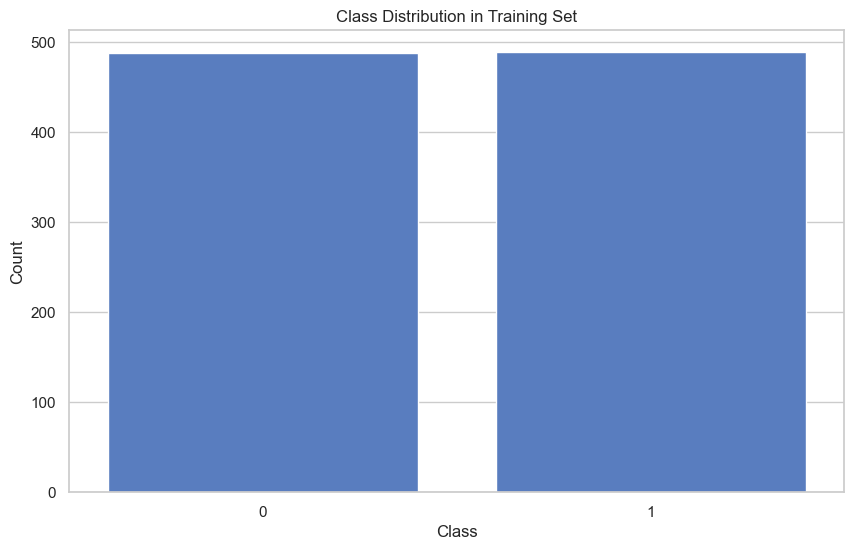

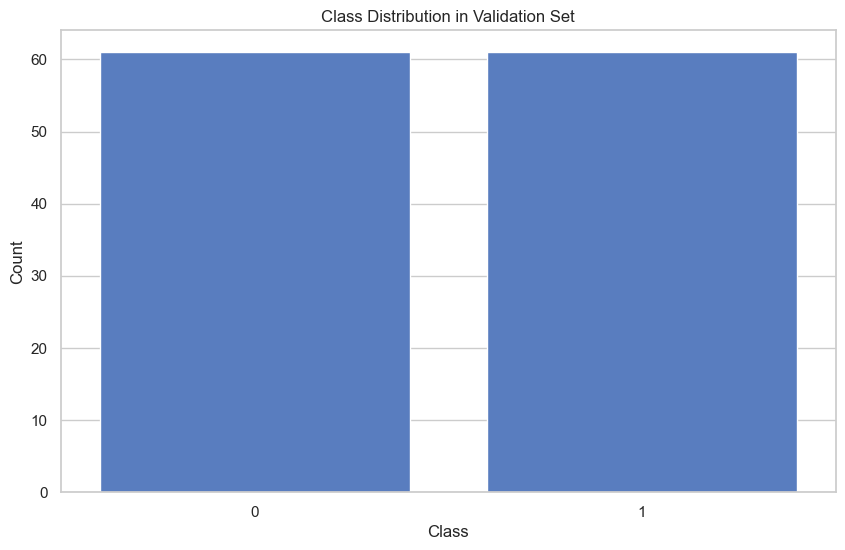

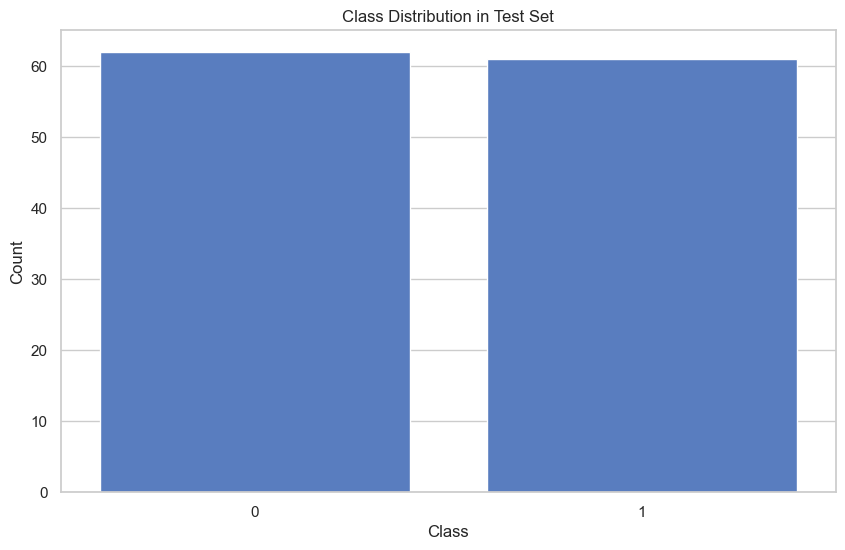

In [3]:
# Initial train/test/validation split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_resampled
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5,  # 50% of the temporary set
    random_state=42, 
    stratify=y_temp
)

# Create dataframes for each set with the target variable
df_train = pd.DataFrame(X_train, columns=X.columns).copy()
df_train['Class'] = y_train.values

df_val = pd.DataFrame(X_val, columns=X.columns).copy()
df_val['Class'] = y_val.values

df_test = pd.DataFrame(X_test, columns=X.columns).copy()
df_test['Class'] = y_test.values

# Display the shapes of the splits
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

# Display class distributions
print("\nClass distribution in training set:")
print(df_train['Class'].value_counts())

print("\nClass distribution in validation set:")
print(df_val['Class'].value_counts())

print("\nClass distribution in test set:")
print(df_test['Class'].value_counts())

# Function to plot class distribution
def plot_class_distribution(df, title):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Class', data=df)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Plot class distributions
plot_class_distribution(df_train, 'Class Distribution in Training Set')
plot_class_distribution(df_val, 'Class Distribution in Validation Set')
plot_class_distribution(df_test, 'Class Distribution in Test Set')

In [4]:
# Build the updated neural network model with increased complexity
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Increased units
    Dense(64, activation='relu'),  # Increased units
    Dense(32, activation='relu'),  # Additional hidden layer
    Dense(1, activation='sigmoid')  # Use 'softmax' if more than two classes
])

# Compile the model with a slower learning rate
optimizer = Adam(learning_rate=0.00003)  # Slower learning rate
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multiple classes
              metrics=['accuracy'])

In [5]:
# Define the early stopping callback with patience of 3
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy'
    patience=3,  # Number of epochs to wait for improvement
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=200,  # Increased number of epochs
    batch_size=32,  # Adjust the batch size as needed
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Include the early stopping callback
)

Epoch 1/200
31/31 [==============================] - 1s 9ms/step - loss: 0.7408 - accuracy: 0.5005 - val_loss: 0.7473 - val_accuracy: 0.4836
Epoch 2/200
31/31 [==============================] - 0s 4ms/step - loss: 0.7262 - accuracy: 0.4985 - val_loss: 0.7352 - val_accuracy: 0.4590
Epoch 3/200
31/31 [==============================] - 0s 4ms/step - loss: 0.7134 - accuracy: 0.4964 - val_loss: 0.7249 - val_accuracy: 0.4590
Epoch 4/200
31/31 [==============================] - 0s 4ms/step - loss: 0.7030 - accuracy: 0.4954 - val_loss: 0.7157 - val_accuracy: 0.4754
Epoch 5/200
31/31 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5261 - val_loss: 0.7094 - val_accuracy: 0.5000
Epoch 6/200
31/31 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.5445 - val_loss: 0.7033 - val_accuracy: 0.4918
Epoch 7/200
31/31 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.5640 - val_loss: 0.6991 - val_accuracy: 0.5164
Epoch 8/200
3

4/4 [==============================] - 0s 3ms/step - loss: 0.5084 - accuracy: 0.7886
Test Loss: 0.5084152817726135
Test Accuracy: 0.7886179089546204


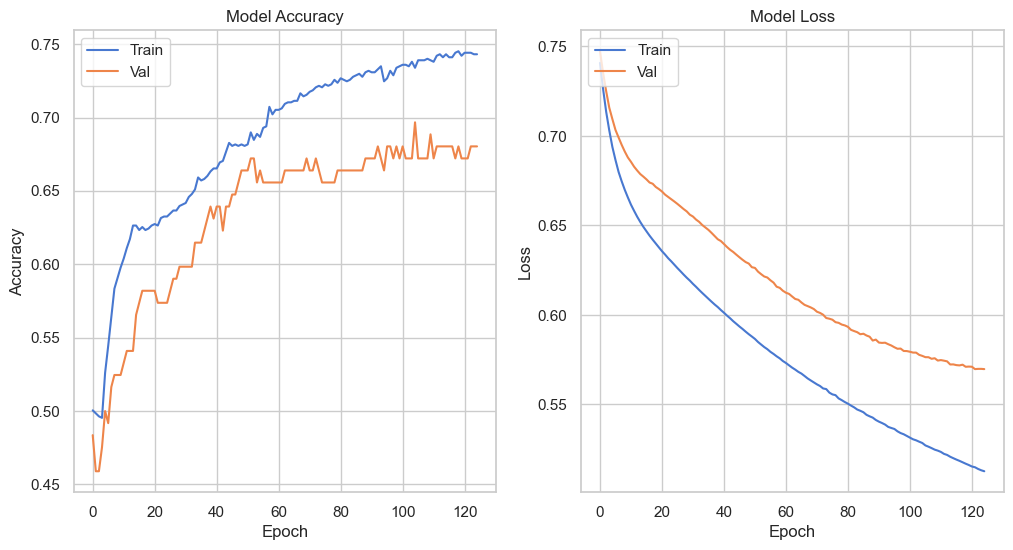

In [6]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()